---
---
# **Notebook Overview: Drug-Likeness Analysis with SMILES**

This notebook evaluates the drug-likeness of molecules by analyzing SMILES strings, calculating essential drug-likeness properties, and visualizing the results.

### **Key Steps**:
1. **Setup**: Install and import required libraries (e.g., RDKit, pandas, seaborn).
2. **Data Loading**: Read SMILES strings from a CSV file.
3. **Descriptor Calculation**: Compute Lipinski Score, molecular weight (MW), LogP, HBD, and HBA.
4. **Save Results**: Export the calculated descriptors to a new CSV file.
5. **Visualizations**: Plot histograms and boxplots for MW, LogP, and Lipinski Score.
6. **Summary Statistics**: Generate and save statistical summaries (mean, std, etc.).
7. **Molecule Comparison**: Compare an input molecule’s properties with the dataset’s averages using a radar chart.

### **Purpose**:
This notebook supports drug discovery by evaluating and visualizing drug-likeness properties, aiding researchers in assessing molecule suitability for further development.

In [1]:
# Install required libraries if not installed
"""
Ensures that all necessary libraries (RDKit, pandas, matplotlib, seaborn)
are installed to run the analysis and generate visualizations.
"""
!pip install rdkit pandas matplotlib seaborn

# Import libraries
"""
Imports essential Python libraries:
- os: For interacting with the file system.
- numpy, pandas: For data manipulation and analysis.
- matplotlib, seaborn: For creating visualizations.
- rdkit: For molecular structure handling and descriptor calculations.
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import ExactMolWt, MolLogP, NumHDonors, NumHAcceptors
from rdkit.Chem.Crippen import MolLogP as CalcCrippenDescriptors
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcTPSA
from rdkit.Chem.Lipinski import NumHDonors as CalcNumLipinskiHBD, NumHAcceptors as CalcNumLipinskiHBA


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 34.3 MB/s eta 0:00:00


---
---
# **Calculate the molecular descriptors**

The code processes molecular data by calculating descriptors for each molecule, such as Molecular Weight (MW), LogP, HBD, HBA, and Lipinski Score. It reads the dataset from `Additional File 1.csv`, applies the `calculate_descriptors` function to each generated SMILES string, and stores the results. Invalid SMILES return `None`, and the final results are saved to a CSV file named `Descriptors_Results.csv`.

In [11]:
# Load the CSV file
data = pd.read_csv("Additional File 1.csv")

# Define a function to calculate descriptors for each SMILES
def calculate_descriptors(smiles):
    """
    Calculates key molecular descriptors based on Lipinski's Rule of Five for drug-likeness.

    Parameters:
    - smiles (str): The SMILES string of the molecule.

    Returns:
    - dict: A dictionary containing the following descriptors:
        - "Lipinski Score" (int): Score indicating adherence to Lipinski's rules (max 4).
        - "MW" (float): Exact molecular weight of the molecule.
        - "LogP" (float): Partition coefficient (lipophilicity) of the molecule.
        - "HBD" (int): Number of hydrogen bond donors.
        - "HBA" (int): Number of hydrogen bond acceptors.

    If the SMILES string is invalid, the function returns None for all descriptors.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)  # Generate molecule object from SMILES
        if not mol:
            raise ValueError(f"Invalid SMILES: {smiles}")
        # Calculate descriptors
        mw = ExactMolWt(mol)
        logp = MolLogP(mol)
        hbd = NumHDonors(mol)
        hba = NumHAcceptors(mol)
        qed = QED.qed(mol)
        tpsa = CalcTPSA(mol)
        # Calculate Lipinski Score (4 rules - number of violations)
        lipinski_score = 4 - sum([mw > 500, logp > 5, hbd > 5, hba > 10])
        return {"Lipinski Score": lipinski_score, "MW": mw, "LogP": logp, "HBD": hbd, "HBA": hba, "QED": qed, "TPSA": tpsa}
    except Exception as e:
        print(f"Error for SMILES {smiles}: {e}")
        return {"Lipinski Score": None, "MW": None, "LogP": None, "HBD": None, "HBA": None, "QED":None, "TPSA":None}

# Calculate descriptors for each row in the dataset
"""
Iterates over each row in the input data, applies the `calculate_descriptors` function
to compute descriptors for the SMILES string, and stores the results in a list.
"""
descriptors = []
for index, row in data.iterrows():
    result = calculate_descriptors(row['generated SMILES'])
    # Add additional information from the dataset
    result['core molecule'] = row['core molecule']
    result['generated SMILES'] = row['generated SMILES']
    descriptors.append(result)

# Create a DataFrame with the computed descriptors
"""
Converts the list of computed descriptors into a pandas DataFrame and saves it as a CSV file.
"""
results_df = pd.DataFrame(descriptors)
results_df.to_csv("Descriptors_Results.csv", index=False)


---
---
# **Plot drug-likeness Distribution**

The code visualizes key molecular properties using different plot types. It first sets up the plot aesthetics with `seaborn`'s `whitegrid` style for clarity. It then displays the distribution of Molecular Weight and LogP values through histograms with Kernel Density Estimate (KDE) overlays, which highlight density trends. Finally, it uses a boxplot to summarize the distribution of Lipinski Scores, providing insights into the range, median, and potential outliers in terms of drug-likeness.

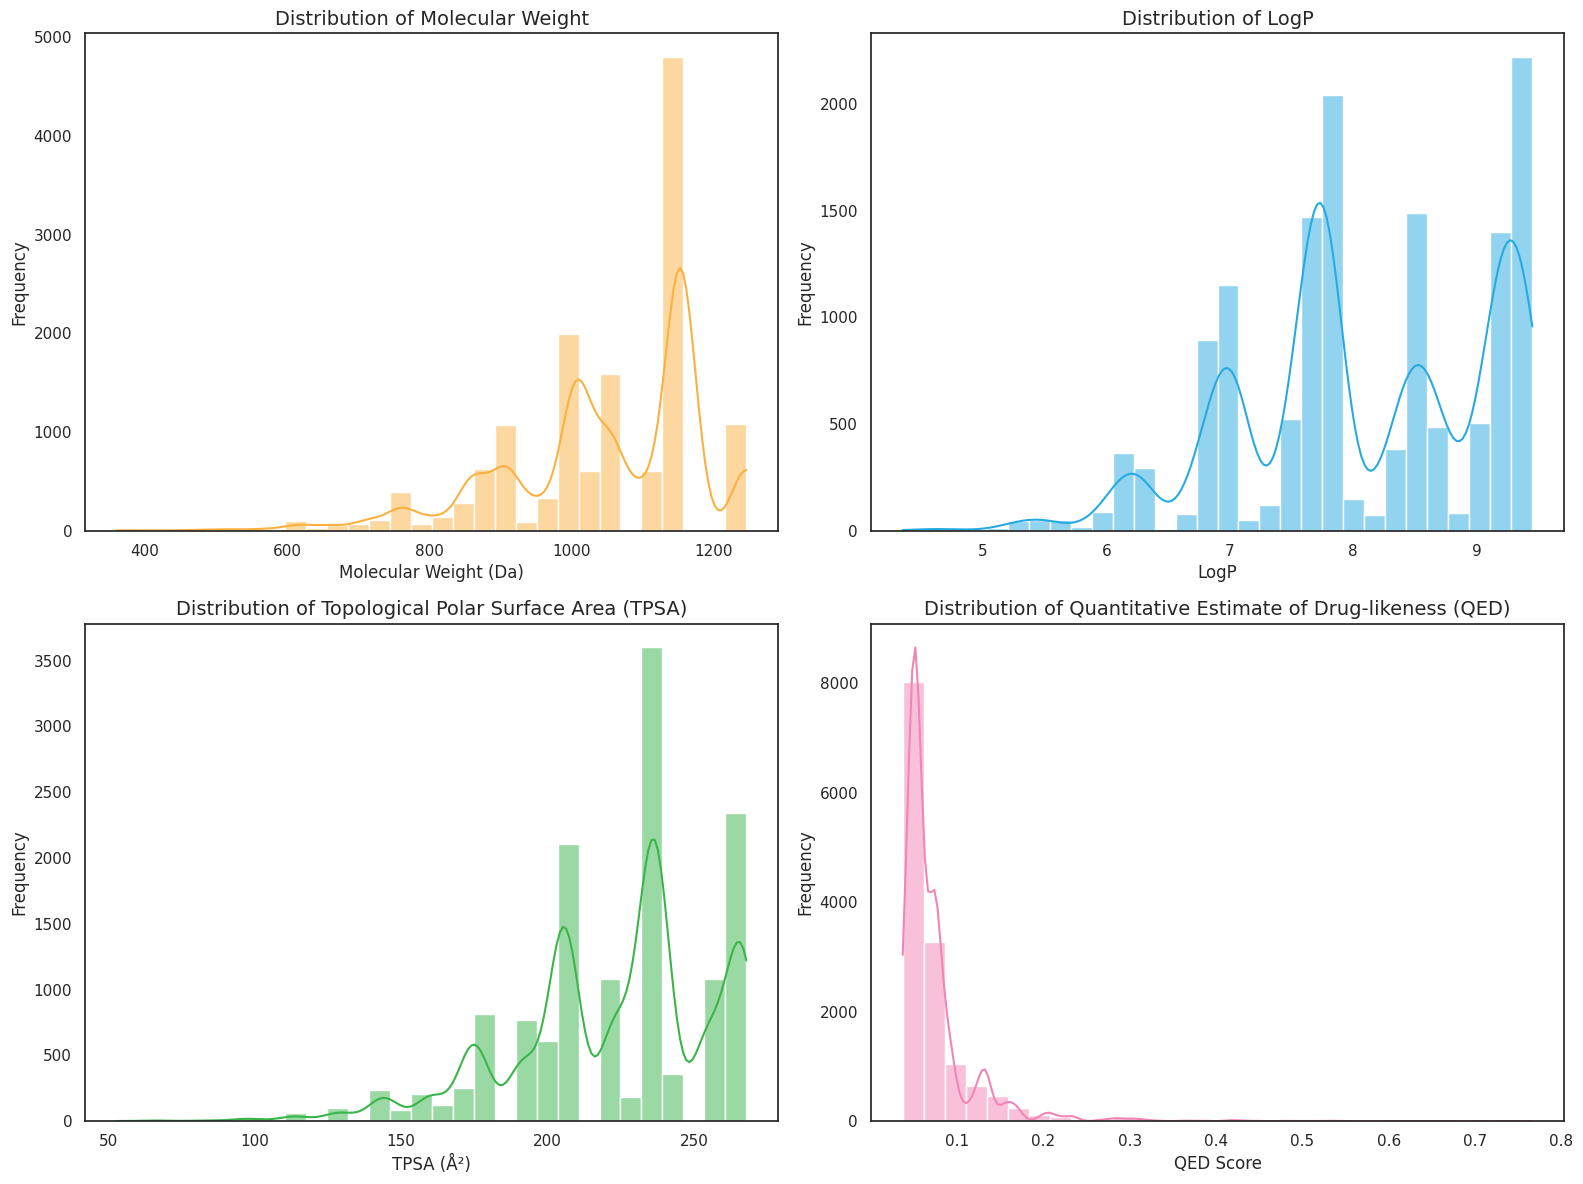

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn style without grid
sns.set(style="white")
sns.color_palette("colorblind")

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot distribution of Molecular Weight (MW)
sns.histplot(results_df['MW'], kde=True, bins=30, color='#FBB040', ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Molecular Weight", fontsize=14)
axes[0, 0].set_xlabel("Molecular Weight (Da)")
axes[0, 0].set_ylabel("Frequency")

# Plot distribution of LogP
sns.histplot(results_df['LogP'], kde=True, bins=30, color='#27AAE1', ax=axes[0, 1])
axes[0, 1].set_title("Distribution of LogP", fontsize=14)
axes[0, 1].set_xlabel("LogP")
axes[0, 1].set_ylabel("Frequency")

# Plot distribution of TPSA
sns.histplot(results_df['TPSA'], kde=True, bins=30, color='#39B54A', ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Topological Polar Surface Area (TPSA)", fontsize=14)
axes[1, 0].set_xlabel("TPSA (Å²)")
axes[1, 0].set_ylabel("Frequency")

# Plot distribution of QED
sns.histplot(results_df['QED'], kde=True, bins=30, color='#F285B5', ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Quantitative Estimate of Drug-likeness (QED)", fontsize=14)
axes[1, 1].set_xlabel("QED Score")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()

# Save the figure as an EPS file
plt.savefig("Molecular_Descriptors_Distributions.eps", format="eps")

plt.show()

In [6]:
# Summary statistics
summary_table = results_df.describe()
print(summary_table)

# Save summary statistics
summary_table.to_csv("Summary_Statistics.csv")


       Lipinski Score            MW          LogP           HBD           HBA  \
count    14074.000000  14074.000000  14074.000000  14074.000000  14074.000000   
mean         1.926602   1044.371185      8.076839      0.382905      9.138340   
std          0.276663    139.820241      1.003115      0.486113      1.219342   
min          1.000000    360.265102      4.349600      0.000000      3.000000   
25%          2.000000    997.567712      7.547300      0.000000      8.000000   
50%          2.000000   1057.531327      7.791900      0.000000      9.000000   
75%          2.000000   1155.591916      9.173700      1.000000     10.000000   
max          4.000000   1245.638866      9.450700      1.000000     11.000000   

                QED          TPSA  
count  14074.000000  14074.000000  
mean       0.073446    222.597496  
std        0.047311     33.915544  
min        0.037046     52.870000  
25%        0.050213    205.620000  
50%        0.057312    234.130000  
75%        0.07510

---
---
# **Calculates the drug-likeness Properties for a Sample SMILES**

This section computes the drug-likeness properties for a sample molecule using its SMILES string and compares them to the mean values from a summary dataset. First, the `Summary_Statistics.csv` file is loaded to obtain the mean values of key drug-likeness properties, such as Lipinski Score, Molecular Weight (MW), LogP, Hydrogen Bond Donors (HBD), and Acceptors (HBA). The input SMILES string for the sample molecule is processed, and the `calculate_descriptors` function is used to compute the corresponding drug-likeness properties. These properties are then compared to the mean values, and a DataFrame is generated for a structured overview of the results.

In [12]:
# Load Summary_Statistics.csv for mean data
summary_data = pd.read_csv('Summary_Statistics.csv')

# Extract mean values
mean_values = {
    'Lipinski': summary_data.iloc[1]['Lipinski Score'],
    'MW': summary_data.iloc[1]['MW'],
    'LogP': summary_data.iloc[1]['LogP'],
    'HBD': summary_data.iloc[1]['HBD'],
    'HBA': summary_data.iloc[1]['HBA'],
    'QED': summary_data.iloc[1]['QED'],
    'TPSA': summary_data.iloc[1]['TPSA'],
}

# Load SMILES and names from Additional File 2.csv
smiles_data = pd.read_csv('Additional File 2.csv')
smiles_dict = dict(zip(smiles_data['given name by Embo-Ibouanga et al'], smiles_data['SMILES']))

# Calculate drug-likeness properties for each molecule
admet_data = {'Property': ['Lipinski', 'MW', 'LogP', 'HBD', 'HBA', 'QED', 'TPSA']}
for name, smile in smiles_dict.items():
    descriptors = calculate_descriptors(smile)
    admet_data[name] = list(descriptors.values())

# Add mean values for comparison
admet_data['Mean'] = list(mean_values.values())

# Create DataFrame for visualization
df = pd.DataFrame(admet_data)
df.set_index('Property', inplace=True)

# Display the data
print(df)


                 A8L        A8DL         A8D         A3L         A3D  \
Property                                                               
Lipinski    2.000000    2.000000    2.000000    2.000000    2.000000   
MW        753.446535  753.446535  753.446535  765.446535  765.446535   
LogP        7.389400    7.389400    7.389400    7.533500    7.533500   
HBD         0.000000    0.000000    0.000000    0.000000    0.000000   
HBA         7.000000    7.000000    7.000000    7.000000    7.000000   
QED         0.147166    0.147166    0.147166    0.155450    0.155450   
TPSA      146.380000  146.380000  146.380000  146.380000  146.380000   

                 A6L         A5L         A5D      AW231         Mean  
Property                                                              
Lipinski    2.000000    2.000000    2.000000    2.00000     1.926602  
MW        855.457099  664.386280  664.386280  652.38628  1044.371185  
LogP        7.648600    6.062700    6.062700    5.91860     8.07683

---
---
# **Spider Plot**

The `spider` function generates a radar chart to compare the drug-likeness properties of a sample molecule with the dataset's mean values. It normalizes the properties by dividing each by the maximum value, ensuring a consistent scale. The chart displays the normalized values for each property (Lipinski Score, MW, LogP, HBD, HBA), with actual values shown as text. The plot is customized with labels, and a title can be added for clarity.

<ipython-input-51-d3d901d1b075>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colorblind_palette = get_cmap("tab10").colors  # Colorblind-friendly palette


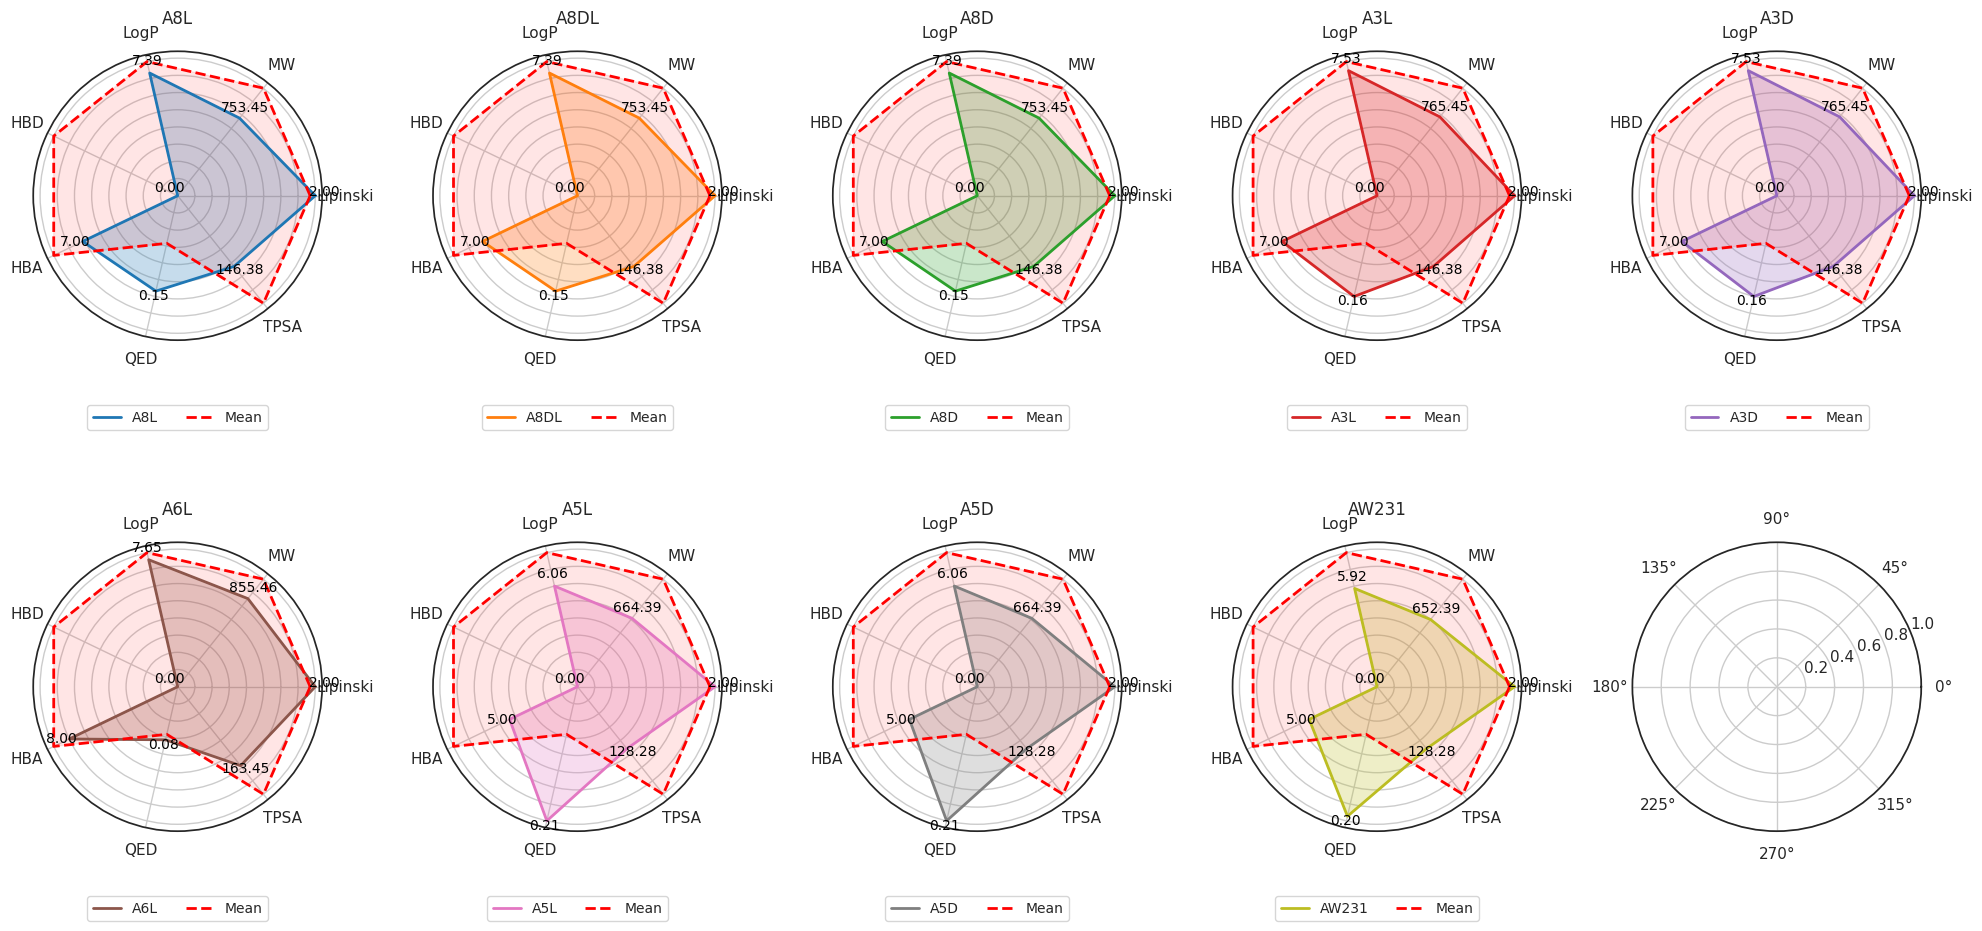

In [51]:
from matplotlib.cm import get_cmap
# Function to create a spider plot
def spider(ax, df, molecule_name, mean_name='Mean', color='blue', padding=1.25):
    categories = df.index.tolist()
    values = df[molecule_name].values
    mean_values = df[mean_name].values

    max_values = padding * np.max(df.values, axis=1)
    normalized_values = values / max_values
    normalized_mean_values = mean_values / max_values

    # Prepare angles for the radar plot
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]

    # Close the plot data
    values = np.append(normalized_values, normalized_values[0])
    mean_values = np.append(normalized_mean_values, normalized_mean_values[0])

    # Plot the data
    ax.plot(angles, values, label=molecule_name, color=color, linestyle='-', linewidth=2)
    ax.fill(angles, values, color=color, alpha=0.25)

    ax.plot(angles, mean_values, label='Mean', linestyle='--', linewidth=2, color='red')
    ax.fill(angles, mean_values, alpha=0.1, color='red')

    # Display actual values on the graph
    for angle, value, actual in zip(angles, values, df[molecule_name].values):
        ax.text(angle, value + 0.05, f'{actual:.2f}', size='small', color='black', ha='center')

    # Customize the plot
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize='small', ncol=2)
    ax.set_title(molecule_name, pad=20)

# Generate a 5x2 grid of spider plots
colorblind_palette = get_cmap("tab10").colors  # Colorblind-friendly palette
molecule_names = list(smiles_dict.keys())

fig, axes = plt.subplots(2, 5, figsize=(20, 10), subplot_kw=dict(polar=True))
axes = axes.flatten()

for i, (ax, molecule_name) in enumerate(zip(axes, molecule_names)):
    color = colorblind_palette[i % len(colorblind_palette)]  # Cycle through the colorblind palette
    spider(ax, df, molecule_name=molecule_name, color=color)

plt.tight_layout()
plt.savefig("spider_grid_plot.eps", format="eps", bbox_inches='tight')
plt.show()